In [1]:
import os
import json
import time
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from playsound import playsound

import psutil
from joblib import Parallel, delayed

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [12]:
# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'SM2RAIN', '1dy'
product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'GSMaP', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : TRMM_3h.json
Number of threads: 20
Neighborhood area: 5x5



In [4]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [10]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [11]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: TRMM_Italy_3hr_1998_01_01_2023_12_31.nc


FileNotFoundError: [Errno 2] No such file or directory: '/media/arturo/Arturo/Data/Italy/Satellite/TRMM/3h/TRMM_Italy_3hr_1998_01_01_2023_12_31.nc'

In [9]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_mean = ds_veneto.resample(time ='D').sum(dim='time', skipna=False).mean(dim='time', skipna=True)
elif time_reso == '1dy':
    PRE_mean = ds_veneto.mean(dim='time', skipna=True)
else:
    raise SystemExit(f"Time resolution not found: {time_reso}")

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

del ds_veneto

PRE_mean

NameError: name 'PRE_data' is not defined

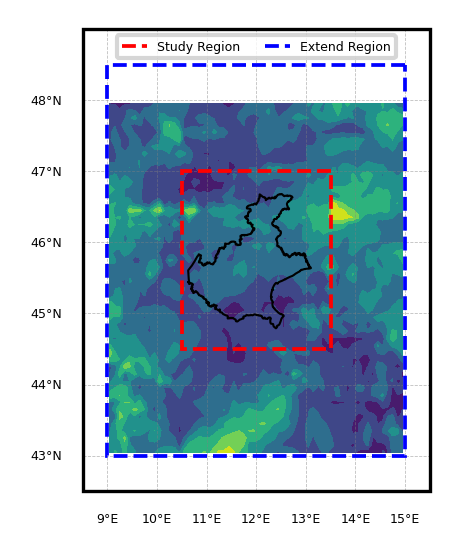

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [9]:
def beta_3h_1dy(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*param['dt']
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        tscales = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])*param['dt']
    else:
        print(f'Erorr: {time_reso} not valid')
        return None
    
    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    BOX = BOX.transpose("lon", "lat", "time")
    BOX = BOX['PRE']
    
    smax = BOX.shape[0]
    tscales = tscales[tscales < param['tmax'] + 0.001]
    xscales = np.arange(1, smax+1)
    xscales_km = xscales*param['L1']
    
    WET_MATRIX = ART_pre.space_time_scales_agregations(
                BOX, 
                param['L1'], 
                param['condition'], 
                tscales, 
                xscales, 
                2*param['npix']+1, 
                param['thresh'])
    
    nxscales = np.size(xscales)
    
    tscales_INTER = np.linspace(np.min(tscales), np.max(tscales), param['ninterp'])
    WET_MATRIX_INTER = np.zeros((param['ninterp'], nxscales))

    for col in range(nxscales):
        WET_MATRIX_INTER[:, col] = np.interp(tscales_INTER, tscales, WET_MATRIX[:, col])

    WET_MATRIX_EXTRA, new_spatial_scale = ART_pre.wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                param['L1'], 
                param['npix'])

    origin_ref = [param['origin_x'], param['origin_t']]
    target_ref = [param['target_x'], param['target_t']]

    beta = ART_down.compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, new_spatial_scale, tscales_INTER)

    return beta


In [10]:
def compute_for_point(lat_idx, lon_idx):
    return beta_3h_1dy(PRE_data, time_reso, lats[lat_idx], lons[lon_idx], param)

In [11]:
Resource = []

start_time = time.time()

results = Parallel(n_jobs=param['BETA_cores'])(
    delayed(compute_for_point)(la, lo) for la in ndices_lat for lo in ndices_lon
    )

end_time = time.time()

elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
memory_consumed = psutil.virtual_memory().used / 1024 ** 3

print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
print(f"Memory consumed: {memory_consumed:.3f} GB")

Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhood area: 5x5
Neighborhoo

In [12]:
if product == 'IMERG' and time_reso == '3h':
    Resource = pd.DataFrame({
                    'Product':product,
                    'Resolution_t':[time_reso],
                    'Cores':param['BETA_cores'],
                    'Time(min)':np.round(elapsed_minutes,3),
                    'memory':np.round(memory_consumed,3)})

    Resource.to_csv(f'../resources/VENETO_{product}_mean_beta_{time_reso}_cores_{str(param['BETA_cores']).zfill(2)}_npix_{NEIBHR}.csv', header=True, index=False)

In [13]:
BETA_VENETO = np.array(results).reshape(len(ndices_lat), len(ndices_lon))

In [14]:
BETA_xr = xr.Dataset(data_vars={"BETA": (("lat","lon"), BETA_VENETO.data)},
                    coords={'lat': lats[ndices_lat], 'lon': lons[ndices_lon]},
                    attrs=dict(description=f"Beta of {product} for Veneto region limited as 10.5E to 13.5E and 44.5N to 47N"))

BETA_xr.BETA.attrs["units"] = "dimensionless"
BETA_xr.BETA.attrs["long_name"] = "Relation between Origin and Tarjet wet fraction"
BETA_xr.BETA.attrs["origname"] = "BETA"

BETA_xr.lat.attrs["units"] = "degrees_north"
BETA_xr.lat.attrs["long_name"] = "Latitude"

BETA_xr.lon.attrs["units"] = "degrees_east"
BETA_xr.lon.attrs["long_name"] = "Longitude"

In [15]:
BETA_xr

<xarray.Dataset> Size: 6kB
Dimensions:  (lat: 25, lon: 30)
Coordinates:
  * lat      (lat) float64 200B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    BETA     (lat, lon) float64 6kB 1.143 1.147 1.148 ... 1.385 1.393 1.346
Attributes:
    description:  Beta of IMERG for Veneto region limited as 10.5E to 13.5E a...

In [16]:
BETA_out = os.path.join(dir_base,'1_BETA',f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{NEIBHR}.nc')
print(f'Export PRE data to {BETA_out}')
BETA_xr.to_netcdf(BETA_out)

Export PRE data to /media/arturo/Arturo/Data/Italy/Satellite/1_BETA/VENETO_BETA_IMERG_1dy_2002_2012_npix_5.nc


Export figure to: ../figures/BETA/VENETO_IMERG_mean_beta_1dy_cores_22_npix_5.png


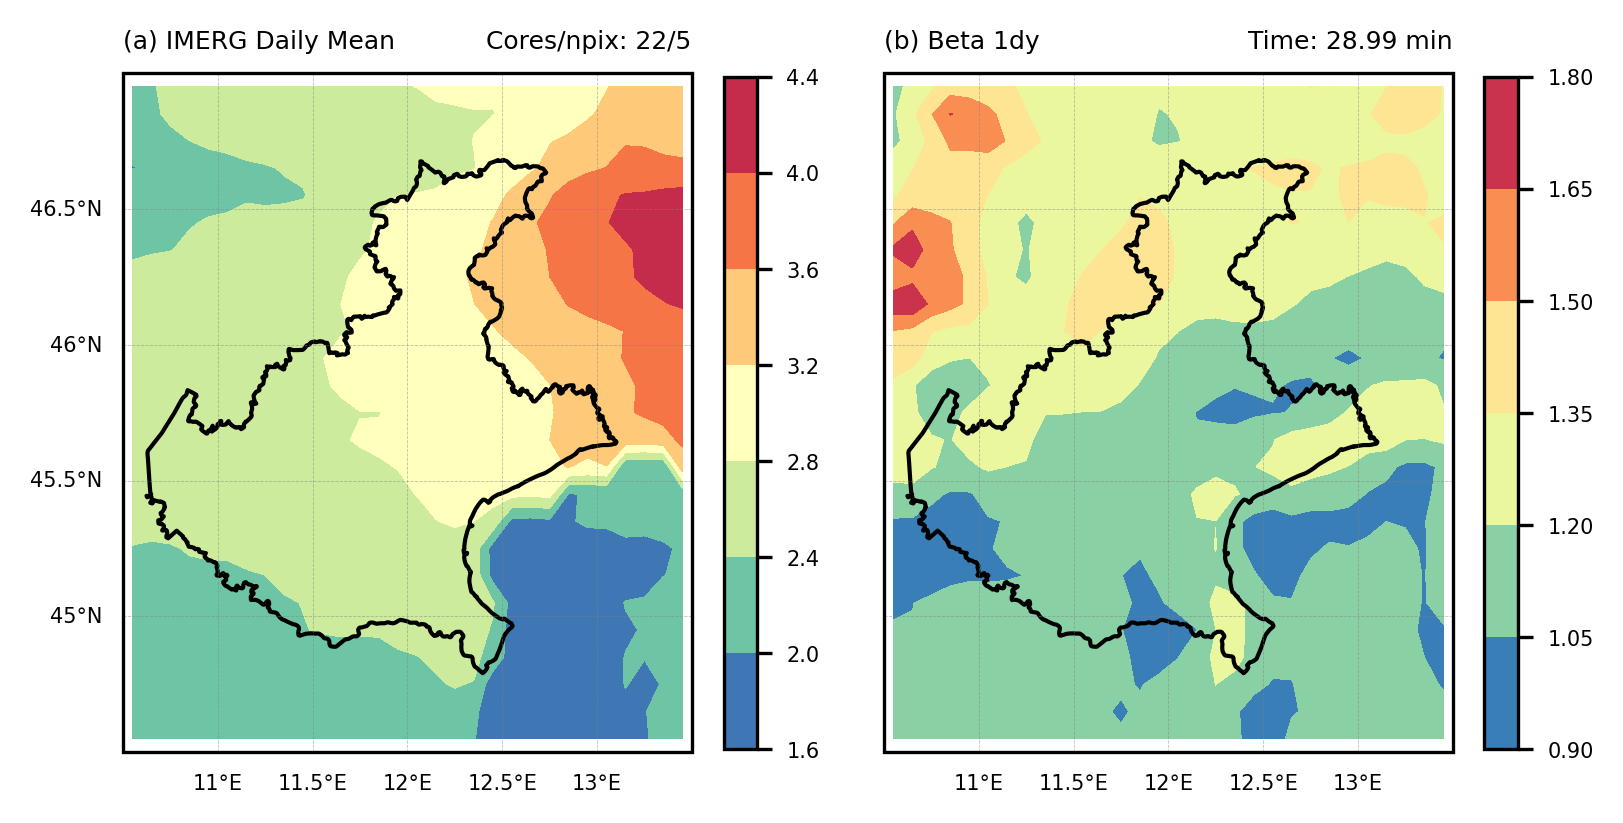

In [17]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d_ref, lat2d_ref, PRE_mean.PRE.values, cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

ax1.set_title(f'(a) {product} Daily Mean', fontsize=6, loc='left')
ax1.set_title(f'Cores/npix: {param['BETA_cores']}/{NEIBHR}', fontsize=6, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d_ref, lat2d_ref, BETA_VENETO, cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=5)

# Variance function between two scales (Gamma)
# Intermitency function between two scales (BETA)
ax1.set_title(f'(b) Beta {time_reso}', fontsize=6, loc='left')
ax1.set_title(f'Time: {elapsed_minutes:.2f} min', fontsize=6, loc='right')

salida = os.path.join('..','figures','BETA',f'VENETO_{product}_mean_beta_{time_reso}_cores_{param['BETA_cores']}_npix_{NEIBHR}.png')
print(f'Export figure to: {salida}')
plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.1, facecolor=None)

In [18]:
playsound("../sound/HOMER_DOH.mp3")